In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler

In [38]:
# Load pre-processed data
SG_FS_CRC_BA = pd.read_csv("SingaporeCRC_data/SG_FS_CRC_BA")
SG_FS_CRC_BA

,patient_id,g__Abyssalbus,g__Abyssibius,g__Abyssicoccus,g__Acaryochloris,g__Aceticella,g__Acetilactobacillus,g__Acetivibrio,g__Acetoanaerobium,g__Acetobacter,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
0,1030,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,...,72.0,Sigmoid colon,Left,2,pT3N0(0/20)M0,IIA,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
1,106,0.0,0.0,0.0,2.0,0.0,0.0,6.0,1.0,0.0,...,72.0,Transverse colon,Right,3,T4aN2(4/29)M0,IIIC,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
2,1076,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,45.0,Cecum,Right,2,pT3N2(6/12)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
3,1079,1.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,1.0,...,65.0,Splenic flexure,Left,2,pT4aN0(0/6)M1,IV,iCMS3,CMS4,iCMS3_MSS,iCMS3_fibrotic
4,1117,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45.0,Rectosigmoid junction,Left,2,pT3N0(0/12)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1658,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,59.0,Rectum,Left,2,T3N2b(8/22)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
109,1662,1.0,0.0,0.0,1.0,0.0,1.0,58.0,0.0,0.0,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
110,1664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,62.0,Sigmoid colon,Left,2,T3N2a(6/29)M0,IIIC,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
111,1665,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,...,78.0,Sigmoid colon,Left,2,T3N1c(0/15)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS


In [39]:
stage_mapping = {
    'I': 'stage I',
    'II': 'stage II',
    'III': 'stage III',
    'IV': 'stage IV',
    'IIA': 'stage II',
    'IIA': 'stage II',
    'IIIB': 'stage III',
    'IIIC': 'stage III',
    'IIC': 'stage II',
    'IIB': 'stage II',
    'IIIA': 'stage III',
    'IVB': 'stage IV',
    'IVA': 'stage IV'
}

SG_FS_CRC_BA['Stage'] = SG_FS_CRC_BA['Stage'].replace(stage_mapping)

In [40]:
class_counts = SG_FS_CRC_BA['Stage'].value_counts()
print(class_counts)

Stage
stage II     35
stage III    34
stage IV     34
stage I      10
Name: count, dtype: int64


In [41]:
# Prepare features and target variable
X = SG_FS_CRC_BA.drop(['patient_id','TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA', 'PIK3R1',
       'SMAD4', 'ERBB4', 'RNF43', 'ZNRF3', 'KIT', 'TGFBR2', 'Vital.status',
       'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = SG_FS_CRC_BA['Stage']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))
print("Shape of y:", X_scaled.shape)
print("Shape of y:", y.shape)

Unique values of y: ['stage I' 'stage II' 'stage III' 'stage IV']
Unique values of y: [0 1 2 3]
Shape of y: (113, 1854)
Shape of y: (113,)


In [42]:
# Oversampling to ensure class balance
from imblearn.over_sampling import SMOTE
#oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
#X_scaled, y = oversampler.fit_resample(X_scaled,y)

sm = SMOTE(sampling_strategy='not majority', k_neighbors= 5, random_state=42)
X_scaled, y = sm.fit_resample(X_scaled, y)

print(X_scaled.shape)
print(y.shape)

(140, 1854)
(140,)


In [43]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=200, random_state=42)
clf = clf.fit(X_scaled, y)
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_scaled)
X_new.shape               

(140, 732)

Best Parameters: {'alpha': 0.1, 'eta': 0.01, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Best Score: 0.42947368421052634
Test Set Accuracy: 0.42857142857142855


<Figure size 800x600 with 0 Axes>

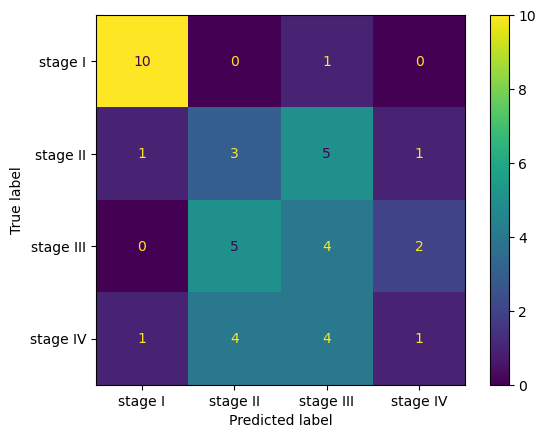

              precision    recall  f1-score   support

     stage I       0.83      0.91      0.87        11
    stage II       0.25      0.30      0.27        10
   stage III       0.29      0.36      0.32        11
    stage IV       0.25      0.10      0.14        10

    accuracy                           0.43        42
   macro avg       0.40      0.42      0.40        42
weighted avg       0.41      0.43      0.41        42



In [44]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Include L1 regularization
    'n_estimators': [50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', seed=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['stage I', 'stage II', 'stage III', 'stage IV'])
plt.figure(figsize=(8, 6))
cm_display.plot()
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['stage I', 'stage II', 'stage III', 'stage IV'])
print(report)

In [45]:
from sklearn.metrics import roc_auc_score

# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', **best_params)
y_score = best_xgb_model.fit(X_train, y_train).predict_proba(X_test)

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.69
Macro-averaged One-vs-Rest ROC AUC score:
0.66


C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_20280\362741267.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2, color='black', label='Chance level (AUC = 0.5)')


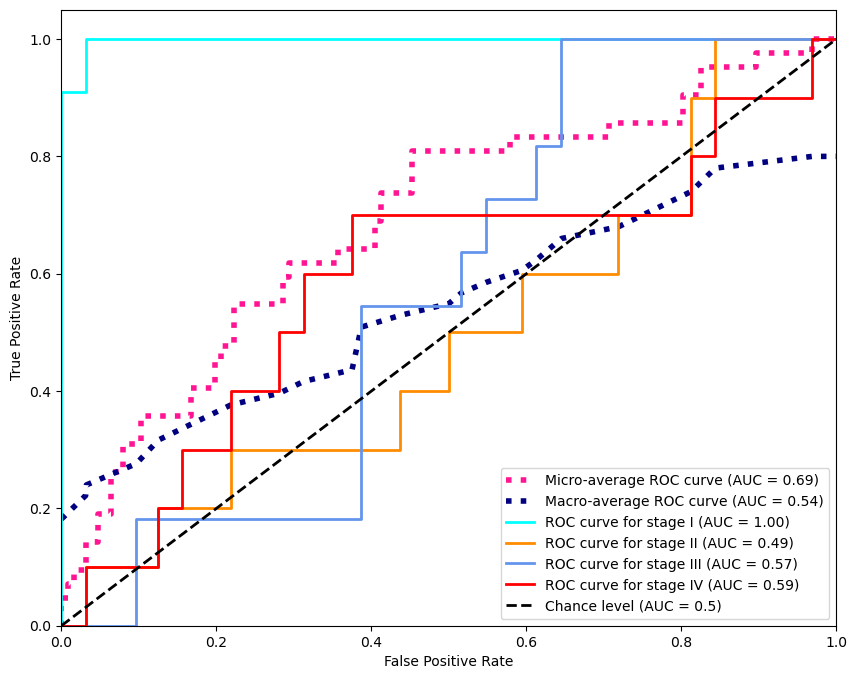

In [46]:
# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=np.arange(4))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve for {0} (AUC = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2, color='black', label='Chance level (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_20280\2470296422.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")


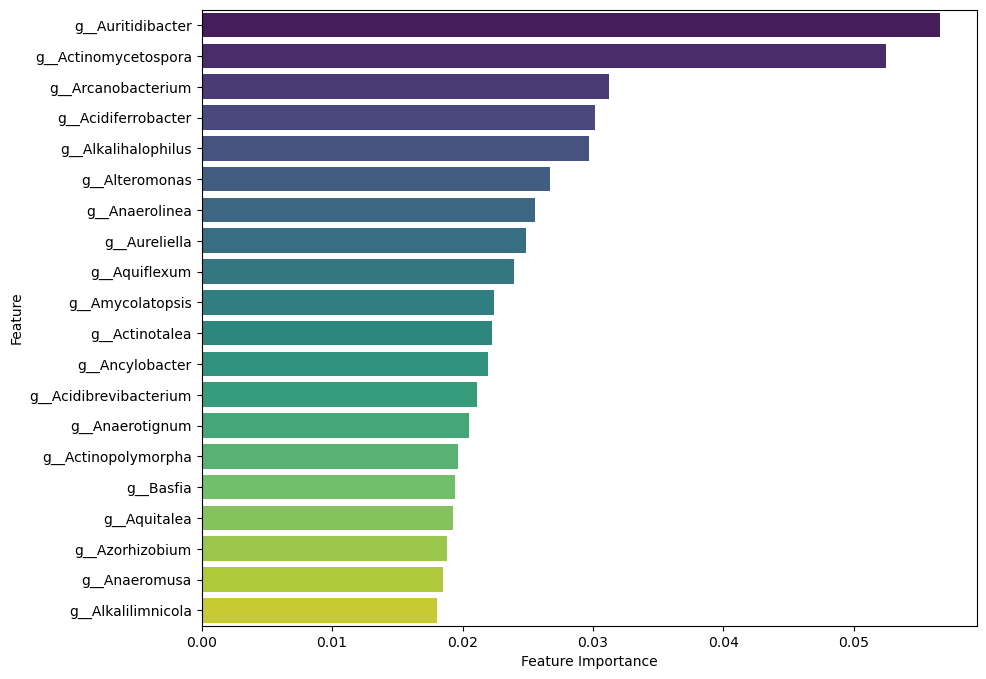

In [35]:
feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

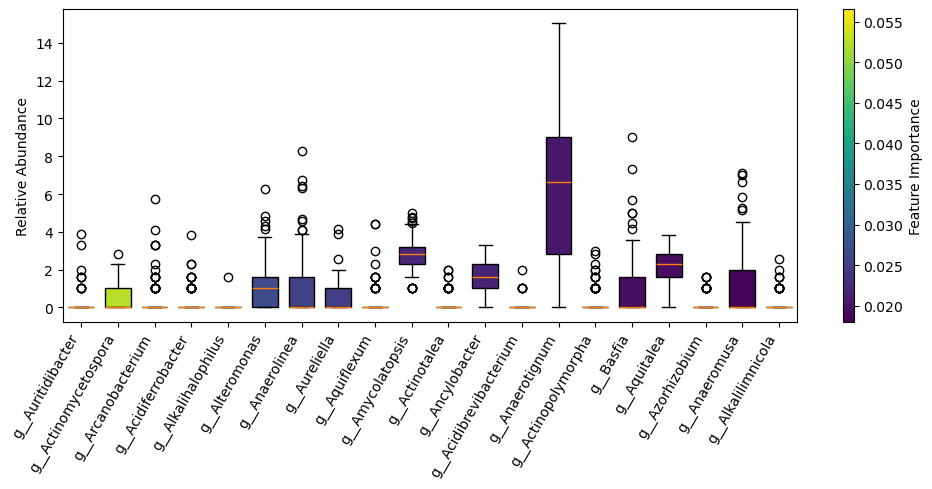

In [36]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

top_20_feature_names = feature_names[top_20_indices]

# Normalize feature importances
norm = Normalize(vmin=min(feature_importances[top_20_indices]), vmax=max(feature_importances[top_20_indices]))
cmap = plt.get_cmap('viridis')  # Choose a colormap
colors = [cmap(norm(importance)) for importance in feature_importances[top_20_indices]]

# Prepare data for boxplot
data = {}
abundance_scaled = np.log2(X+1)

for column_name in top_20_feature_names:
    data[column_name] = abundance_scaled[column_name]

# Plot boxplot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each box with the corresponding color based on feature importance
for i, (key, value) in enumerate(data.items()):
    box = ax.boxplot(value, positions=[i + 1], widths=0.7, patch_artist=True,
                     boxprops=dict(facecolor=colors[i], color='black'),
                     whiskerprops=dict(color='black'))

# Customize plot
ax.set_ylabel('Relative Abundance', fontsize=10)
ax.set_xticks(range(1, len(data) + 1))
ax.set_xticklabels(data.keys(), rotation=60, ha='right', fontsize=10)
plt.tight_layout()

# Add colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for colorbar, not for plotting
cbar = plt.colorbar(sm, ax=ax, aspect=30)
cbar.set_label('Feature Importance', fontsize=10)

plt.show()